## Body weight dynamics in DO mice

### Load preamble

In [1]:
from __future__ import absolute_import
from __future__ import print_function

import warnings
warnings.filterwarnings("ignore")

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

%config Completer.use_jedi = False

In [2]:
import os
import sys
import argparse
import pickle
import pandas as pd
import numpy as np
from functools import partial

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
plt.rcParams["font.family"] = "Arial"

os.chdir("../")
sys.path.append(os.getcwd())

from viarhmm.preprocess import load_data
from viarhmm.preprocess import split_train_validation
from viarhmm.preprocess import train_viarhmm
from viarhmm.preprocess import viarhmm_train_fn
from viarhmm.preprocess import validate_viarhmm
from viarhmm.preprocess import viarhmm_validation_fn
from viarhmm.preprocess import compute_deviances
from viarhmm.utils import gradient_cmap
from viarhmm.analysis.create_dataframe import build_dataframe

%load_ext autoreload
%autoreload 2

In [3]:
def save_figure(fdir, fname):

  # save figure
  ftypes = ['.pdf']
  os.makedirs(fdir, exist_ok=True)
  for ftype in ftypes:
    plt.savefig(os.path.join(fdir, fname + ftype),
                bbox_inches='tight',
                dpi=300)
  return

### Load settings

In [4]:
def make_rgb_transparent(rgb, bg_rgb, alpha):
    return [alpha * c1 + (1 - alpha) * c2 for (c1, c2) in zip(rgb, bg_rgb)]

# Hex color codes
diet_colors = []
hex_codes = {"AL": "#8B8682", "1D": "#87CEEB", "2D": "#27408B", "20": "#FFA500", "40": "#B22222"}
diet_colors = []
for key, value in hex_codes.items():
  rgb_tuple = tuple(int(value[i:i+2], 16) / 255 for i in (1, 3, 5))
  diet_colors.append(sns.set_hls_values(rgb_tuple))

color_names = [
    "yellow tan",
    "pastel blue",
    "light sage",
    ]

colors = sns.xkcd_palette(color_names)
cmap = gradient_cmap(colors)

In [5]:
START_K = 2
STOP_K = 11
STEP_K = 1
START_M = 1
STOP_M = 2
STEP_M = 1
TRAIN_FRACTION = 0.7
LEN_THRESHOLD = 70
MAX_SEED = 10
L1_TREND = False
TRIM_PRE = False
MODEL_DIR = 'models/all_models'
DB_NAME = 'data/body_weight.raw.pkl'
ERR_SIGMA = 2.0
FIGS_DIR = 'images/'
ST_DIR = 'models/best_model/seed_8/threshold_2.0/state_transitions'

BODYWEIGHT_DATASET = "data/bodyweight.csv"

### Load data

In [6]:
# load dataframes
df_raw_bw, df_l1f_bw, df_trim_bw = load_data(db_name=DB_NAME,
                                             l1_trend=L1_TREND,
                                             trim_pre=TRIM_PRE)

# select the dataframe of interest
df_bw = df_raw_bw.copy()
if L1_TREND:
    df_bw = df_l1f_bw.copy()

if TRIM_PRE:
    df_bw = df_trim_bw.copy()

Extracting raw measurements from data/body_weight.raw.pkl
Removing:  DO-1D-3005
Removing:  DO-1D-3025
Removing:  DO-2D-4060
Removing:  DO-AL-0022


In [7]:
df_bw

,bw.30.days,bw.40.days,bw.50.days,bw.60.days,bw.70.days,bw.80.days,bw.90.days,bw.100.days,bw.110.days,bw.120.days,...,bw.1560.days,bw.1570.days,bw.1580.days,bw.1590.days,bw.1600.days,bw.1610.days,bw.1620.days,bw.1630.days,mouse_id,diet
0,20.0,20.000,21.00,22.970,23.74,26.790,30.31,31.530,32.610,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DO-1D-3001,1D
1,19.0,19.000,18.00,21.270,22.43,24.540,27.03,28.465,30.460,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DO-1D-3002,1D
2,17.0,17.000,18.00,19.310,18.81,18.755,19.52,20.455,20.700,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DO-1D-3003,1D
3,18.0,19.000,20.00,21.785,22.07,22.775,24.61,26.465,27.730,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DO-1D-3004,1D
5,19.0,20.000,21.00,24.010,23.50,25.330,26.63,27.835,27.110,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DO-1D-3006,1D
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
955,NaN,18.990,19.94,20.805,21.61,23.270,20.01,21.760,21.200,25.62,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DO-AL-0188,AL
956,NaN,26.005,29.38,31.270,32.25,34.470,31.37,31.340,34.850,37.82,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DO-AL-0189,AL
957,NaN,22.315,24.48,26.720,29.35,29.490,29.24,31.700,34.100,35.42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DO-AL-0190,AL
958,NaN,22.670,26.24,26.430,27.71,30.040,27.32,26.440,27.845,30.22,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DO-AL-0191,AL


### Load models

In [8]:
print(f'Using body weight measurements from {DB_NAME}.')
print(f'Fititng MSAR models hidden states k=range(start={START_K}, stop={STOP_K}, '
        f'step={STEP_K}) and lag orders m=range(start={START_M}, stop={STOP_M}, '
        f'step={STEP_M}).')
ks = range(START_K, STOP_K, STEP_K)
ms = range(START_M, STOP_M, STEP_M)
print(f'Fitting models for hidden states: {ks}')
print(f'Fitting models for lag orders: {ms}')

Using body weight measurements from data/body_weight.raw.pkl.
Fititng MSAR models hidden states k=range(start=2, stop=11, step=1) and lag orders m=range(start=1, stop=2, step=1).
Fitting models for hidden states: range(2, 11)
Fitting models for lag orders: range(1, 2)


In [9]:
tmodels = []
vmodels = []

for seed in range(MAX_SEED):

  # get model dir
  model_dir = os.path.join(MODEL_DIR, 'seed_' + str(seed))

  if ERR_SIGMA:
    model_dir = os.path.join(model_dir, 'threshold_' + str(ERR_SIGMA))
    threshold = ERR_SIGMA
  else:
    threshold = None

  # split into train and validation data
  tdatas, vdatas, ttags, vtags, n_train, \
      n_validation, diets = split_train_validation(df_bw,
                                                   len_threshold=LEN_THRESHOLD,
                                                   train_fraction=TRAIN_FRACTION,
                                                   random_state=seed)

  # train models
  _viarhmm_train_fn = partial(viarhmm_train_fn, random_state=seed)
  viarhmm_models = train_viarhmm(viarhmm_train_fn=_viarhmm_train_fn,
                                  ks=ks,
                                  ms=ms,
                                  tdatas=tdatas,
                                  inputs=None,
                                  masks=None,
                                  ttags=ttags,
                                  model_dir=model_dir,
                                  threshold=threshold)

  # validation models
  validation_models = validate_viarhmm(viarhmm_validation_fn=viarhmm_validation_fn,
                                        models=viarhmm_models,
                                        ks=ks,
                                        ms=ms,
                                        vdatas=vdatas,
                                        inputs=None,
                                        masks=None,
                                        vtags=vtags,
                                        model_dir=model_dir,
                                        threshold=threshold)


  # append models
  tmodels.append(viarhmm_models)
  vmodels.append(validation_models)

1D (132, 164) (58, 164)
20 (133, 164) (59, 164)
2D (133, 164) (58, 164)
40 (133, 164) (59, 164)
AL (133, 164) (58, 164)
Saved models/all_models/seed_0/threshold_2.0/viarhmm_model_2_1.pkl.
Saved models/all_models/seed_0/threshold_2.0/viarhmm_model_3_1.pkl.
Saved models/all_models/seed_0/threshold_2.0/viarhmm_model_4_1.pkl.
Saved models/all_models/seed_0/threshold_2.0/viarhmm_model_5_1.pkl.
Saved models/all_models/seed_0/threshold_2.0/viarhmm_model_6_1.pkl.
Saved models/all_models/seed_0/threshold_2.0/viarhmm_model_7_1.pkl.
Saved models/all_models/seed_0/threshold_2.0/viarhmm_model_8_1.pkl.
Saved models/all_models/seed_0/threshold_2.0/viarhmm_model_9_1.pkl.
Saved models/all_models/seed_0/threshold_2.0/viarhmm_model_10_1.pkl.
Saved models/all_models/seed_0/threshold_2.0/validate_model_2_1.pkl.
Saved models/all_models/seed_0/threshold_2.0/validate_model_3_1.pkl.
Saved models/all_models/seed_0/threshold_2.0/validate_model_4_1.pkl.
Saved models/all_models/seed_0/threshold_2.0/validate_model_

### Model selection

#### Calculate deviance information criteria

In [10]:
def get_deviances(all_models, df):

  deviances = np.zeros((MAX_SEED, STOP_K-START_K))
  for s in range(MAX_SEED):

    tdatas, vdatas, ttags, vtags, n_train, \
      n_validation, diets = split_train_validation(df,
                                                  len_threshold=LEN_THRESHOLD,
                                                  train_fraction=TRAIN_FRACTION,
                                                  random_state=s)
    seed_models = all_models[s]
    for m, model in enumerate(seed_models):
      dic = compute_deviances(model=model, datas=vdatas, tags=vtags)
      deviances[s, m] = sum(dic.values())

  return deviances

dics = get_deviances(vmodels, df_bw)

1D (132, 164) (58, 164)
20 (133, 164) (59, 164)
2D (133, 164) (58, 164)
40 (133, 164) (59, 164)
AL (133, 164) (58, 164)
1D (132, 164) (58, 164)
20 (133, 164) (59, 164)
2D (133, 164) (58, 164)
40 (133, 164) (59, 164)
AL (133, 164) (58, 164)
1D (132, 164) (58, 164)
20 (133, 164) (59, 164)
2D (133, 164) (58, 164)
40 (133, 164) (59, 164)
AL (133, 164) (58, 164)
1D (132, 164) (58, 164)
20 (133, 164) (59, 164)
2D (133, 164) (58, 164)
40 (133, 164) (59, 164)
AL (133, 164) (58, 164)
1D (132, 164) (58, 164)
20 (133, 164) (59, 164)
2D (133, 164) (58, 164)
40 (133, 164) (59, 164)
AL (133, 164) (58, 164)
1D (132, 164) (58, 164)
20 (133, 164) (59, 164)
2D (133, 164) (58, 164)
40 (133, 164) (59, 164)
AL (133, 164) (58, 164)
1D (132, 164) (58, 164)
20 (133, 164) (59, 164)
2D (133, 164) (58, 164)
40 (133, 164) (59, 164)
AL (133, 164) (58, 164)
1D (132, 164) (58, 164)
20 (133, 164) (59, 164)
2D (133, 164) (58, 164)
40 (133, 164) (59, 164)
AL (133, 164) (58, 164)
1D (132, 164) (58, 164)
20 (133, 164) (5

#### Calculate ELBOs

In [11]:
def get_elbos(all_models):

  elbos = np.zeros((MAX_SEED, STOP_K-START_K))
  for s in range(MAX_SEED):
    seed_models = all_models[s]
    for m, model in enumerate(seed_models):
      elbos[s, m] = model.elbos[-1]
  return elbos

elbos = get_elbos(tmodels)

#### Plot DIC, ELOBs

Best seed:  8


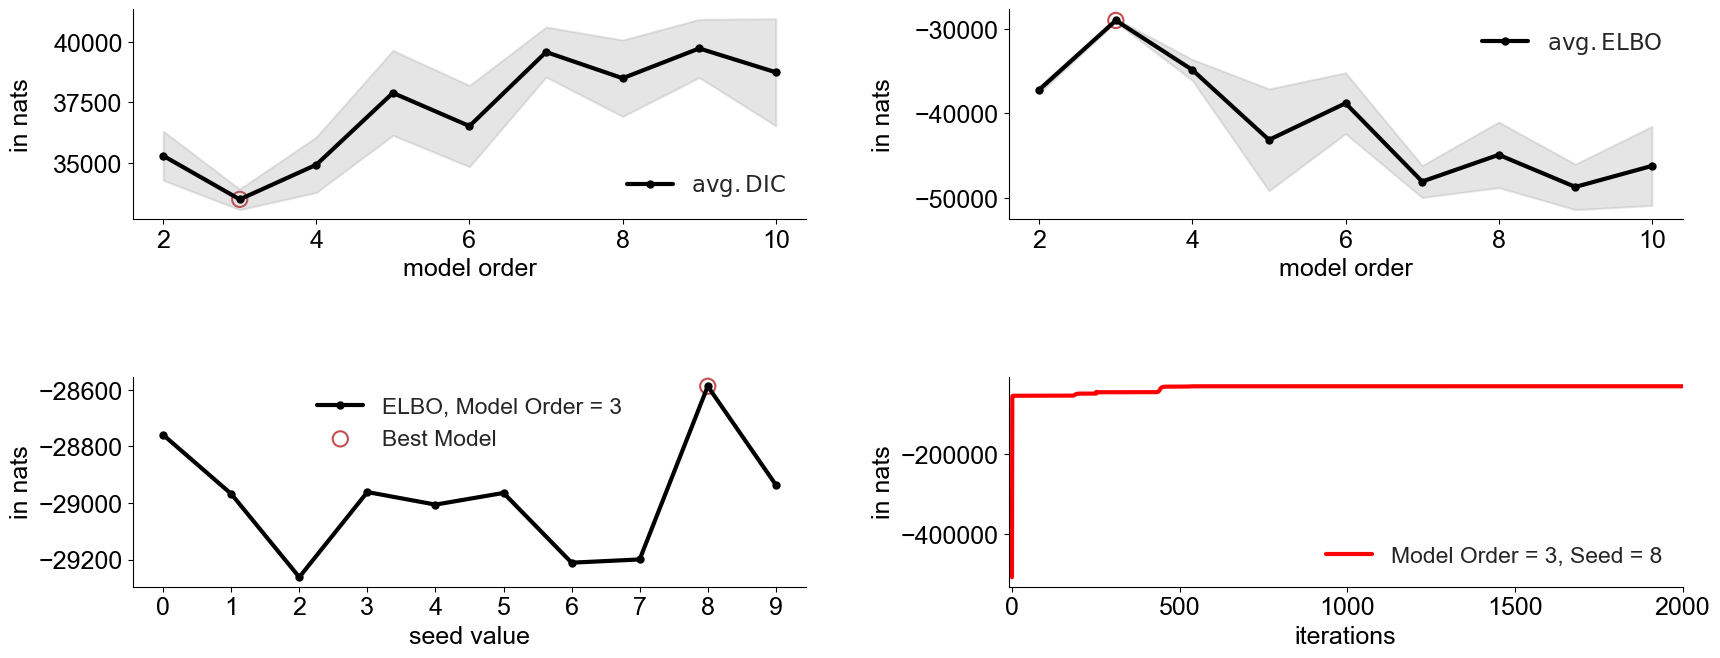

In [12]:
def plot_model_selection(tmodels, vmodels, dics, elbos, save=False, fname=None):

  def get_models(models, model_order=5, start_k=START_K):
    smodels = []
    for seed in range(MAX_SEED):
      smodels.append(models[seed][model_order-start_k])
    return smodels

  def best_elbos(models):
    elbos = []
    for model in models:
      elbos.append(model.elbos[-1])
    seed = np.asarray(elbos).argmax()
    print("Best seed: ", seed)
    return seed

  fig, ax = plt.subplots(figsize=(20, 7.5), nrows=2, ncols=2)
  ax = ax.ravel()
  sns.set(font_scale=1.01)
  sns.set_style("white")
  sns.set_context("talk")
  posx = np.arange(START_K, STOP_K)

  ### deviance information criteria
  mean_devs = np.mean(dics, axis=0)
  std_devs = np.std(dics, axis=0)

  ax[0].plot(posx, mean_devs, color='black', marker='o', linewidth=3,
             markersize=5, label=r'$\mathrm{avg. DIC}$')
  ax[0].scatter(posx[1], mean_devs[1], s=120, facecolors='none', edgecolors='r')
  ax[0].fill_between(posx, mean_devs-std_devs, mean_devs+std_devs, alpha=0.2,
                     color="gray")
  ax[0].spines['right'].set_visible(False)
  ax[0].spines['top'].set_visible(False)
  ax[0].spines['left'].set_visible(True)
  ax[0].spines['bottom'].set_visible(True)
  ax[0].tick_params(axis='x', which='major', bottom=True, labelsize=18)
  ax[0].tick_params(axis='y', which='major', left=True, labelsize=18)
  ax[0].legend(frameon=False, loc="lower right")
  ax[0].set_xlabel("model order", fontsize=18)
  ax[0].set_ylabel("in nats", fontsize=18)

  ### evidence based lower bound
  mean_elbos = np.mean(elbos, axis=0)
  std_elbos = np.std(elbos, axis=0)

  ax[1].plot(posx, mean_elbos, color='black', marker='o', linewidth=3,
             markersize=5, label=r'$\mathrm{avg. ELBO}$')
  ax[1].scatter(posx[1], mean_elbos[1], s=120, facecolors='none', edgecolors='r')
  ax[1].fill_between(posx, mean_elbos-std_elbos, mean_elbos+std_elbos, alpha=0.2,
                     color="gray")
  ax[1].spines['right'].set_visible(False)
  ax[1].spines['top'].set_visible(False)
  ax[1].spines['left'].set_visible(True)
  ax[1].spines['bottom'].set_visible(True)
  ax[1].tick_params(axis='x', which='major', bottom=True, labelsize=18)
  ax[1].tick_params(axis='y', which='major', left=True, labelsize=18)
  ax[1].legend(frameon=False, loc="upper right")
  ax[1].set_xlabel("model order", fontsize=18)
  ax[1].set_ylabel("in nats", fontsize=18)

  ### elbo for model order and seed value
  model_order = 3
  smodels = get_models(tmodels, model_order=model_order)
  bs = best_elbos(smodels)
  posx = np.arange(0, MAX_SEED)

  ax[2].plot(posx, elbos[:, model_order-START_K], color='black', marker='o',
             linewidth=3, markersize=5, label=r'ELBO, Model Order = 3')
  ax[2].scatter([bs], elbos[bs, model_order-START_K], s=120, facecolors='none',
                edgecolors='r', label='Best Model')
  ax[2].set_xticks(posx)
  ax[2].set_xticklabels(posx)

  ax[2].spines['right'].set_visible(False)
  ax[2].spines['top'].set_visible(False)
  ax[2].spines['left'].set_visible(True)
  ax[2].spines['bottom'].set_visible(True)
  ax[2].tick_params(axis='x', which='major', bottom=True, labelsize=18)
  ax[2].tick_params(axis='y', which='major', left=True, labelsize=18)
  ax[2].legend(frameon=False, loc="upper center")
  ax[2].set_xlabel("seed value", fontsize=18)
  ax[2].set_ylabel("in nats", fontsize=18)

  ### elbo vs iterations
  ax[3].plot(smodels[bs].elbos, label='Model Order = 3, Seed = ' + str(bs),
             color="red", linewidth=3)
  ax[3].spines['right'].set_visible(False)
  ax[3].spines['top'].set_visible(False)
  ax[3].spines['left'].set_visible(True)
  ax[3].spines['bottom'].set_visible(True)
  ax[3].tick_params(axis='x', which='major', bottom=True, labelsize=18)
  ax[3].tick_params(axis='y', which='major', left=True, labelsize=18)
  ax[3].set_xlabel("iterations", fontsize=18)
  ax[3].set_ylabel("in nats", fontsize=18)
  ax[3].legend(frameon=False, loc="lower right")
  ax[3].set_xlim([-10, 2000])

  fig.align_labels()
  fig.subplots_adjust(hspace=0.75, wspace=0.3)

  # save figure
  if save and (fname is not None):
    save_figure(fdir="images",
                fname=fname)
  plt.show()
  return
  
plot_model_selection(tmodels, vmodels, dics, elbos, save=False, fname="model_selection")

### Create dataframe using best model

In [13]:
if os.path.exists(BODYWEIGHT_DATASET):
  df_data = pd.read_csv(BODYWEIGHT_DATASET, sep=',', index_col=[0, 1])
else:
  df_data = build_dataframe(df_bw, tmodels, vmodels)
  df_data.to_csv('data/bodyweight.csv', sep=',')

### Trajectories

#### All trajectories (across diets)

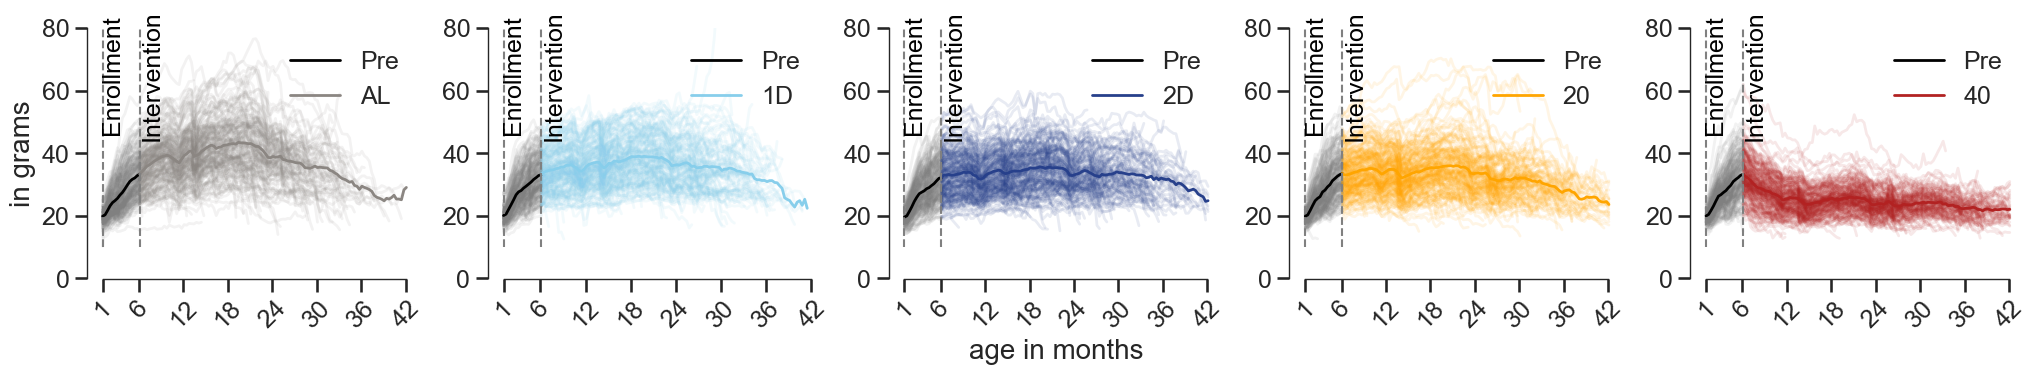

In [14]:
def plot_bw_trajectories_by_diet(df, save=False):

  diets = ["AL", "1D", "2D", "20", "40"]

  # Same layout as above
  fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(25, 3.25),
                          sharex=True, sharey=True)
  axs = axs.ravel()
  sns.set(font_scale=1.05)
  sns.set_style("white")
  sns.set_context("talk")
  ax = plt.subplot(1, 1, 1)

  MAX_DURATION = 1260
  S = 1

  mouse_ids = df.index.get_level_values(0).unique().to_list()

  for a, (ax, diet) in enumerate(zip(axs, diets)):

    ax = plt.subplot(1, len(diets), a+1)
    # ax = axs[a]

    # select mouse id by diet
    smouse_ids = []
    for mouse_id in mouse_ids:
      sdiet = mouse_id.split('-')[1]
      if sdiet == diet:
        smouse_ids.append(mouse_id)

    # get body weight data
    bw_data = []
    for mouse_id in smouse_ids:
      data = df.loc[(mouse_id, "bw")].to_numpy().astype(float)
      bw_data.append(data)

    bw_data = np.vstack(bw_data)
    M, N = bw_data.shape
    x_range = np.arange(30, 30+N*10, 10)
    mask = x_range <= MAX_DURATION
    x_range = x_range[mask]
    L = len(x_range)
    avg_bw = np.nanmean(bw_data[:, :L], axis=0)
    std_err = np.nanstd(bw_data[:, :L], axis=0)

    for j in range(M):
      if L > 15:
        plt.plot(x_range[:16], bw_data[j, :16], linewidth=2, color="gray",
               alpha = 0.1)
        plt.plot(x_range[15:L], bw_data[j, 15:L], linewidth=2, color=diet_colors[a],
               alpha = 0.1)
      else:
        plt.plot(x_range, bw_data[j, :L], linewidth=2, color="gray",
               alpha = 0.1)

    plt.plot(x_range[:16], avg_bw[:16], linewidth=2, color="black", label="Pre")

    plt.plot(x_range[15:], avg_bw[15:], linewidth=2, color=diet_colors[a], label=diet)

    plt.plot([180, 180], [10, 80], linewidth=1.5, linestyle='--', color='gray')
    plt.plot([30, 30], [10, 80], linewidth=1.5, linestyle='--', color='gray')

    ax.text(
      x=70,
      y=65.0,
      s="Enrollment",
      ha="center",
      va="center",
      rotation=90,
      rotation_mode="anchor",
      fontsize=18,
      fontweight="regular",
      color="black"
    )
    ax.text(
      x=230,
      y=65.0,
      s="Intervention",
      ha="center",
      va="center",
      rotation=90,
      rotation_mode="anchor",
      fontsize=18,
      fontweight="regular",
      color="black"
    )


    plt.setp(ax.spines.values(), linewidth=1)
    sns.despine(offset=0.5, trim=False)
    ax.tick_params(axis='y', which='major', left=True, labelsize=18)

    xticks = np.arange(0, 1261, 180)
    # xticklabels = [str(x // 30) + ' months' for x in xticks]
    xticklabels = [str(x // 30) for x in xticks]
    xticks = xticks[1:] - 3
    xticks = np.concatenate(([30], xticks), axis=0)
    xticklabels = xticklabels[1:]
    # xticklabels = ['1 month'] + xticklabels
    xticklabels = ['1'] + xticklabels
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels, fontsize=18)
    if a == 2:
      ax.set_xlabel("age in months", fontsize=20)
    ax.tick_params(axis='x', which='major', bottom=True, labelsize=18, rotation=45)
    ax.set_ylim([0, 80])

    if a == 0:
      ax.set_ylabel("in grams", fontsize=20)
    ax.legend(frameon=False, loc="upper right", fontsize=18)

    sns.despine(offset=0.5, trim=True)

  if save:
    save_figure(fdir="images", fname='flat_bodyweight_vs_diet_and_age')
    
  plt.show()
  return

plot_bw_trajectories_by_diet(df_data, save=True)

#### Average trajectory (across diets)

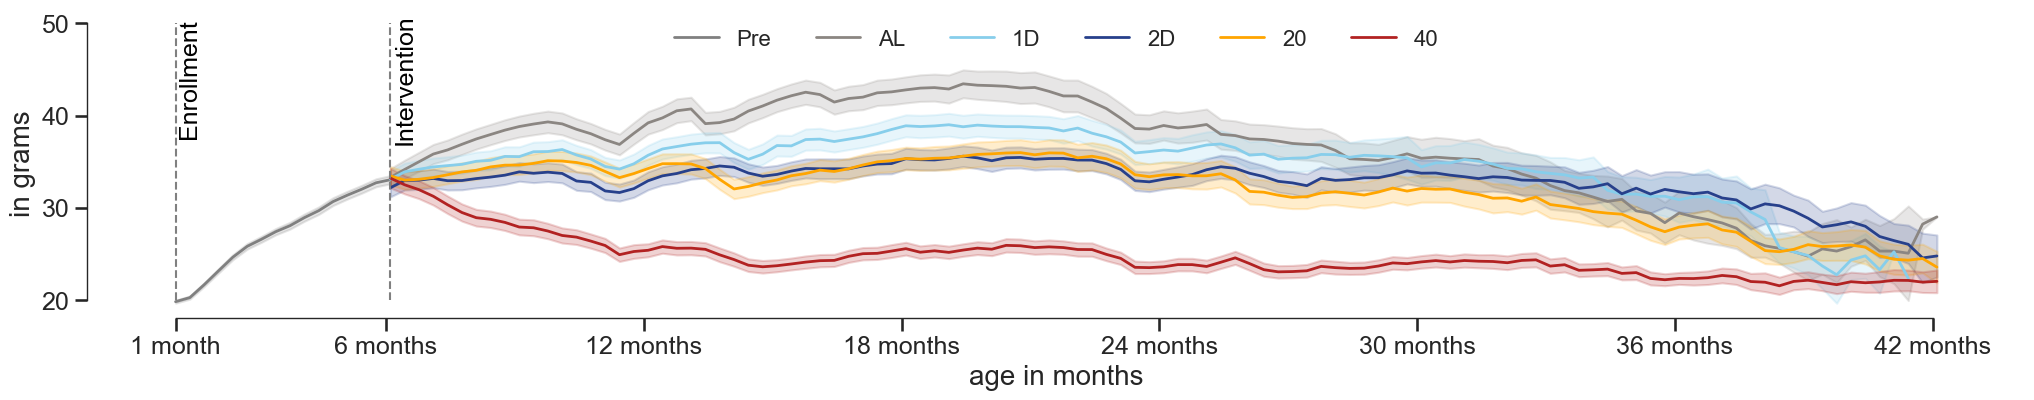

In [15]:
def plot_bw_trajectories(df, save=False):

  diets = ["AL", "1D", "2D", "20", "40"]
  # Hex color codes
  hex_codes = {"Pre": "#8B8682", "AL": "#8B8682", "1D": "#87CEEB", "2D": "#27408B", "20": "#FFA500", "40": "#B22222"}
  diet_colors = []
  for key, value in hex_codes.items():
    rgb_tuple = tuple(int(value[i:i+2], 16) / 255 for i in (1, 3, 5))
    diet_colors.append(sns.set_hls_values(rgb_tuple))
  
  plt.figure(figsize=(25, 4))
  sns.set(font_scale=1.05)
  sns.set_style("white")
  sns.set_context("talk")
  ax = plt.subplot(1, 1, 1)

  MAX_DURATION = 1260
  S = 1

  mouse_ids = df.index.get_level_values(0).unique().to_list()

  # pre intervention
  bw_data = []
  for mouse_id in mouse_ids:
    data = df.loc[(mouse_id, "bw")].to_numpy().astype(float)
    bw_data.append(data)

  bw_data = np.vstack(bw_data)
  M, N = bw_data.shape
  x_range = np.arange(30, 30+N*10, 10)
  mask = x_range <= MAX_DURATION
  x_range = x_range[mask]
  L = len(x_range)
  avg_bw = np.nanmean(bw_data[:, :L], axis=0)
  std_err = np.divide(np.nanstd(bw_data[:, :L], axis=0),
                      np.sqrt(np.sum(~np.isnan(bw_data[:, :L]), axis=0)))
  # std_err = np.nanstd(bw_data[:, :L], axis=0)

  plt.plot(x_range[:16], avg_bw[:16], linewidth=2, color="gray", label="Pre")
  plt.fill_between(x=x_range[:16], y1=avg_bw[:16]-1.96*std_err[:16],
                   y2=avg_bw[:16]+1.96*std_err[:16], alpha=0.2, color="gray")


  # post intervention
  for i, diet in enumerate(diets):

    smouse_ids = []
    for mouse_id in mouse_ids:
      sdiet = mouse_id.split('-')[1]
      if sdiet == diet:
        smouse_ids.append(mouse_id)

    bw_data = []
    for mouse_id in smouse_ids:
      data = df.loc[(mouse_id, "bw")].to_numpy().astype(float)
      bw_data.append(data)

    bw_data = np.vstack(bw_data)
    M, N = bw_data.shape
    x_range = np.arange(30, 30+N*10, 10)
    mask = x_range <= MAX_DURATION
    x_range = x_range[mask]
    L = len(x_range)
    avg_bw = np.nanmean(bw_data[:, :L], axis=0)
    std_err = np.divide(np.nanstd(bw_data[:, :L], axis=0),
                        np.sqrt(np.sum(~np.isnan(bw_data[:, :L]), axis=0)))
    # std_err = np.nanstd(bw_data[:, :L], axis=0)

    plt.plot(x_range[15:], avg_bw[15:], linewidth=2, color=diet_colors[i+1], label=diet)
    plt.fill_between(x=x_range[15:], y1=avg_bw[15:]-1.96*std_err[15:],
                     y2=avg_bw[15:]+1.96*std_err[15:],
                     alpha=0.2, color=diet_colors[i+1])

  plt.plot([180, 180], [20, 50], linewidth=1.5, linestyle='--', color='gray')
  plt.plot([30, 30], [20, 50], linewidth=1.5, linestyle='--', color='gray')
  ax.text(
      x=40,
      y=44.0,
      s="Enrollment",
      ha="center",
      va="center",
      rotation=90,
      rotation_mode="anchor",
      fontsize=18,
      fontweight="regular",
      color="black"
  )
  ax.text(
      x=190,
      y=44.0,
      s="Intervention",
      ha="center",
      va="center",
      rotation=90,
      rotation_mode="anchor",
      fontsize=18,
      fontweight="regular",
      color="black"
  )

  plt.setp(ax.spines.values(), linewidth=1)
  sns.despine(offset=0.5, trim=False)
  ax.tick_params(axis='y', which='major', left=True, labelsize=18)

  xticks = np.arange(0, 1261, 180)
  xticklabels = [str(x // 30) + ' months' for x in xticks]
  xticks = xticks[1:] - 3
  xticks = np.concatenate(([30], xticks), axis=0)
  xticklabels = xticklabels[1:]
  xticklabels = ['1 month'] + xticklabels
  ax.set_xticks(xticks)
  yticks = np.arange(20, 60, 10)
  ax.set_yticks(yticks)
  ax.set_yticklabels(yticks)
  ax.set_xticklabels(xticklabels, fontsize=18)
  ax.tick_params(axis='x', which='major', bottom=True, labelsize=18)

  plt.ylabel("in grams", fontsize=20)
  plt.xlabel("age in months", fontsize=20)

  plt.legend(frameon=False, fontsize=16, loc="upper center", ncol=6)

  sns.despine(offset=0.5, trim=True)

  if save:
    save_figure(fdir="images", fname='bodyweight_vs_age')
    
  plt.show()
  return

plot_bw_trajectories(df_data, save=False)

### Sample mouse

#### Body weight trajectory and latent states

DO-1D-3145


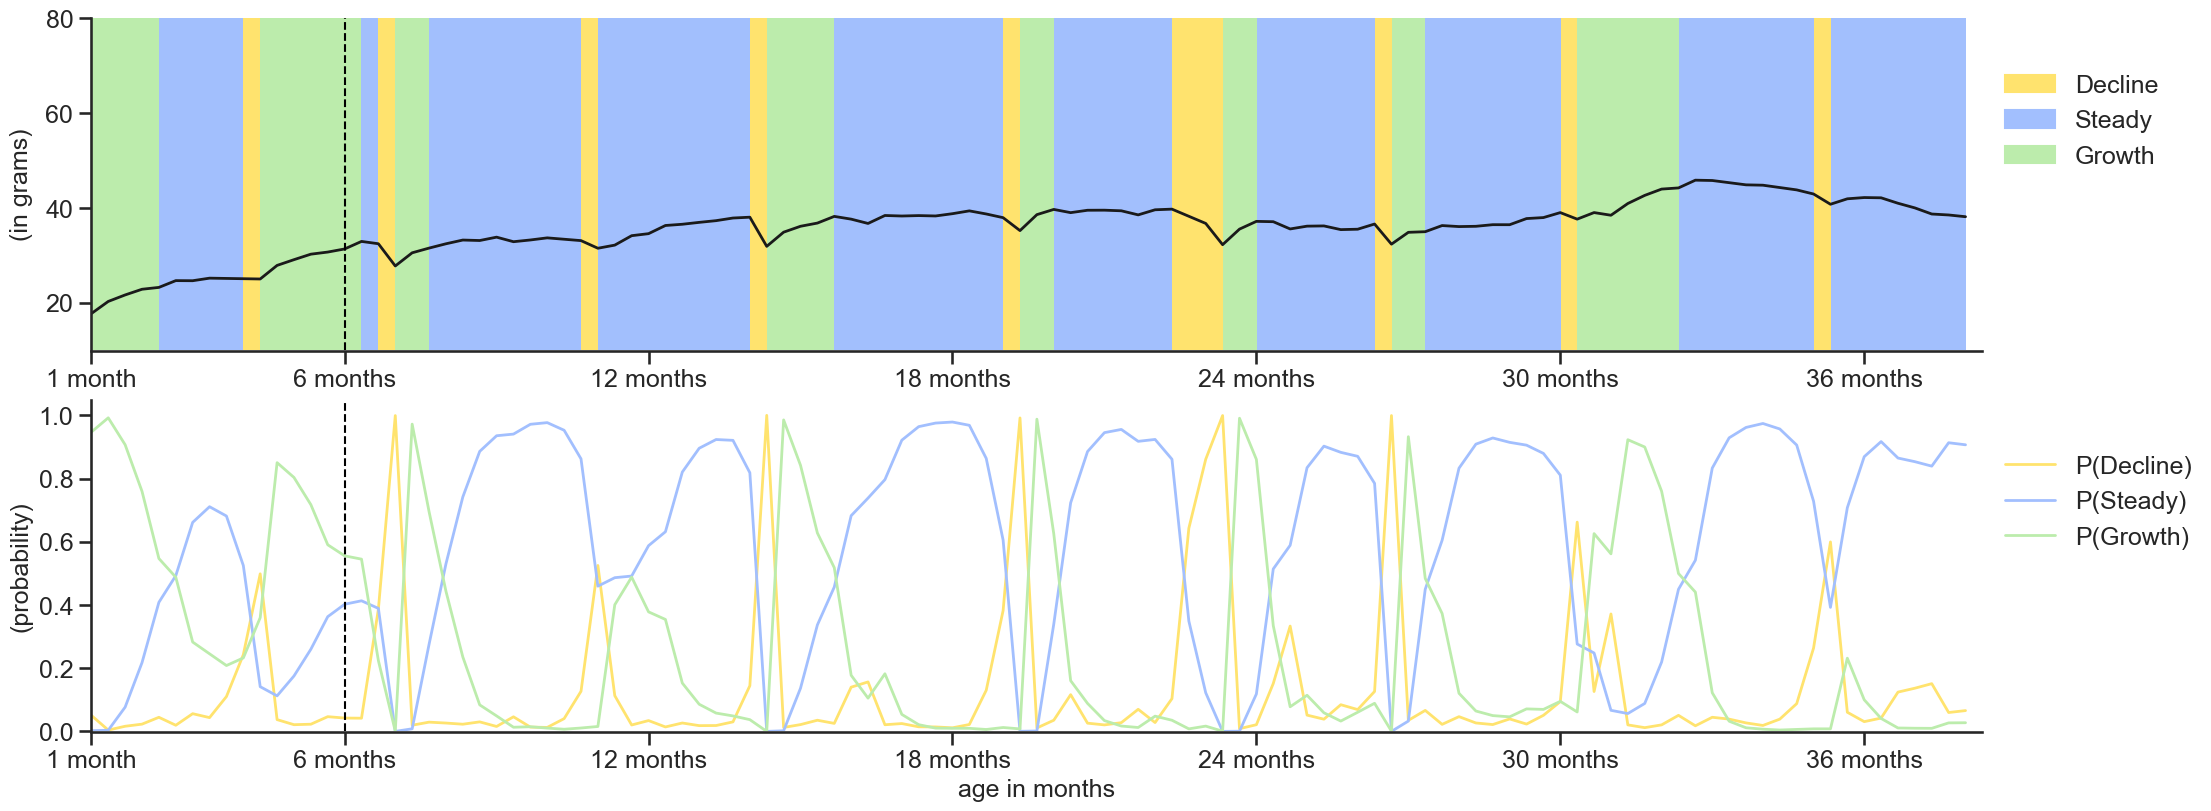

In [16]:
def plot_sample_mouse_bwd(df_data, mouse_ids=['DO-1D-3145'], save=False):

  df = df_data.copy()
  N = len(mouse_ids)

  fig = plt.figure(figsize=(22, 8), constrained_layout=False)
  spec = gridspec.GridSpec(2*N, 1, figure=fig)

  for m, mouse_id in enumerate(mouse_ids):
    print(mouse_id)

    data = df.loc[(mouse_id, "bw")].to_numpy().astype(float)
    state = df.loc[(mouse_id, "states")].to_numpy().astype(float)
    lambdas = df.loc[(mouse_id, "homeostasis")].to_numpy().astype(float)
    pheno = df.loc[(mouse_id, "phenotypes")].to_list()
    events = list(df.loc[(mouse_id, "phenotypes")].unique())
    if '' in events:
      events.remove('')

    start_stop = df.loc[(mouse_id, "events")].to_numpy().astype(float)
    start_stop = start_stop.astype(int)
    start, = np.where(start_stop == 1)
    stop, = np.where(start_stop == -1)

    L = len(state[~np.isnan(state)].astype(int))

    # data with states
    #####################
    ax = fig.add_subplot(spec[2*m, 0])
    ax.imshow(state[None, 1:L],
              aspect="auto",
              cmap=cmap,
              vmin=0,
              vmax=len(colors)-1,
              extent=(0, L-1, 10, 80))
    ax.plot(data[:L], '-k', linewidth=2)
    ax.axvline(x=(180 - 30) // 10, color="black", linestyle="--", linewidth=1.50)

    for event in events:
      ipheno = np.asarray([p for p, ph in enumerate(pheno) if ph == event])
      for ind in ipheno:
        if ind >= L:
          continue
        ax.axvline(x=ind, color='none', linestyle="--", linewidth=1.25)

    ax.set_ylim([10, 80])
    ax.set_xlim([0, L])
    xticks = np.arange(0, L, 18)
    xticklabels = [str(x // 3) + ' months' for x in xticks]
    xticks = xticks[1:] - 3
    xticks = np.concatenate(([0], xticks), axis=0)
    xticklabels = xticklabels[1:]
    xticklabels = ['1 month'] + xticklabels
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels, fontsize=14)

    sns.despine(offset=0.5, trim=False)
    ax.tick_params(axis='x', which='major', bottom=True)
    ax.tick_params(axis='y', which='major', left=True)
    xticks = np.arange(0, L, 18)
    xticks = xticks[1:] - 3
    xticks = np.concatenate(([0], xticks), axis=0)
    ax.set_xticks(xticks)
    ax.tick_params(axis='both', which='major', labelsize=18)

    patches = []
    full_state_names = ["Decline", "Steady", "Growth"]
    state_names = ['DS', 'SS', 'GS']

    for j, color in zip(range(3), colors):
      patches.append(mpatches.Patch(color=color, label=full_state_names[j]))
    ax.legend(handles=patches, frameon=False, bbox_to_anchor=(1.0, 0.9),
              fontsize=18)

    ax.set_ylabel("(in grams)", fontsize=18)

    # probabilities
    ###################
    ax = fig.add_subplot(spec[2*m+1, 0])
    for j in range(3):
      tilda = "pi_" + str(j)
      tilda_pi = df.loc[(mouse_id, tilda)].to_numpy().astype(float)
      # ax.plot(np.arange(0, L), tilda_pi[:L], color=colors[j], linewidth=2,
      #         label=r"$\pi_{:d}$".format(j))
      ax.plot(np.arange(0, L), tilda_pi[:L], color=colors[j], linewidth=2,
              label=r"P(" + full_state_names[j] + ")")

    ax.plot(data, '-k')
    ax.axvline(x=(180 - 30) // 10, color="black", linestyle="--", linewidth=1.50)

    ax.set_ylim([-0, 1.05])
    ax.set_xlim([0, L])

    sns.despine(offset=0.5, trim=False)
    ax.tick_params(axis='x', which='major', bottom=True)
    ax.tick_params(axis='y', which='major', left=True)
    # ax.set_title("Hidden State Probabilities")

    xticks = np.arange(0, L, 18)
    xticks = xticks[1:] - 3
    xticks = np.concatenate(([0], xticks), axis=0)
    ax.set_xticks(xticks)
    ax.set_xticklabels([])
    ax.tick_params(axis='both', which='major', labelsize=18)
    ax.legend(frameon=False, bbox_to_anchor=(1.0,0.9), fontsize=18)

    ax.set_xlim([0, L])
    ax.set_ylim([-0, 1.05])

    sns.despine(offset=0.5, trim=False)
    ax.tick_params(axis='x', which='major', bottom=True)
    ax.tick_params(axis='y', which='major', left=True)

    xticks = np.arange(0, L, 18)
    xticklabels = [str(x // 3) + ' months' for x in xticks]
    xticks = xticks[1:] - 3
    xticks = np.concatenate(([0], xticks), axis=0)
    xticklabels = xticklabels[1:]
    xticklabels = ['1 month'] + xticklabels
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels, fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=18)
    ax.set_ylabel("(probability)", fontsize=18)
    ax.set_xlabel("age in months", fontsize=18)


  fig.align_labels()
  fig.subplots_adjust(hspace=0.95)

  # save figure
  if save:
    save_figure(fdir='figure2',
                fname='sample_mouse_trajectory')

  plt.show()
  return

plot_sample_mouse_bwd(df_data, mouse_ids=["DO-1D-3145"], save=False)